2024-09-19 - Ronen Shekel

In [1]:
from lab.mplc.discrete_scan_result import DiscreetScanResult
%matplotlib ipympl
import glob, os, sys, datetime
import numpy as np
import matplotlib.pyplot as plt
from pianoq_results.scan_result import ScanResult
from pianoq_results.misc import my_mesh
from pianoq.misc.misc import detect_gaussian_spots_subpixel
from pianoq.misc.mplt import mimshow
from pianoq.simulations.mplc_sim.mplc_sim_result import MPLCSimResult
from matplotlib.patches import Rectangle

dir_path = r'G:\My Drive\Projects\MPLC\results\lab\2024_09_19_filters_80nm'


cant use py_thorlabs_ctrl.kinesis
could not import ThorlabsRotatingServoMotor


# Goals
I didn't have enough signal, so I wanted to check whether switching from 20nm filters to 80nm is possible without things going too bad. Ohad showed a while ago that it hurts the fidelity, but currently I don't really care that much about numbers, I just want quick results to better understand the system. 

So I begin by re-running with 20nm some discreet scan, and showing its results in single counts and coincidence. Then I  switch to the 80n filters and see the differences. I will then also look at the two-photon speckle with the new 80nm filters. 

# Single counts 
Here are the single counts I measured a few days ago with 20 nm, and the new ones with 80nm: 

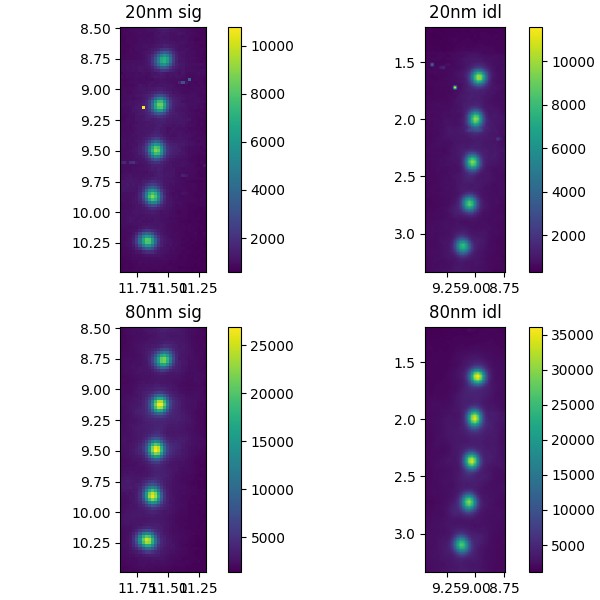

In [10]:
s20_sig_path = glob.glob(rf'{dir_path}\*signal*filter_20nm*.scan')[0]
s20_idl_path = glob.glob(rf'{dir_path}\*idler*filter_20nm*.scan')[0]
s20_sig = ScanResult(path=s20_sig_path)
s20_idl = ScanResult(path=s20_idl_path)


s80_sig_path = glob.glob(rf'{dir_path}\*signal*filter_80nm*.scan')[0]
s80_idl_path = glob.glob(rf'{dir_path}\*idler*filter_80nm*.scan')[0]
s80_sig = ScanResult(path=s80_sig_path)
s80_idl = ScanResult(path=s80_idl_path)

fig, axes = plt.subplots(2, 2, constrained_layout=True, figsize=(6, 6))
my_mesh(s20_sig.X, s20_sig.Y, s20_sig.single2s, axes[0, 0], title='20nm sig')
my_mesh(s20_idl.X, s20_idl.Y, s20_idl.single1s, axes[0, 1], title='20nm idl')

my_mesh(s80_sig.X, s80_sig.Y, s80_sig.single2s, axes[1, 0], title='80nm sig')
my_mesh(s80_idl.X, s80_idl.Y, s80_idl.single1s, axes[1, 1], title='80nm idl')

axes[0, 0].invert_xaxis()
axes[0, 1].invert_xaxis()
axes[1, 0].invert_xaxis()
axes[1, 1].invert_xaxis()

It seems like the spot locations remain largly the same, with the same stoop shape at the bottom for instance. This is good, and indicates that the WFM works OK also for 80nm filters. A closer look shows that the spot location does change by ~10um, as evident by looking at the difference between the spot locations. It is actually kind of weird, it seems like all the spots together moved by some amount, and then there is some jitter. Maybe some backlash issue? (ALL the values of the difference are positive). With the signal things are closer, within 5 um, but still all positive. Maybe when I changed the filters I made something move a few microns. 

In [3]:
locs_20_idl = detect_gaussian_spots_subpixel(s20_idl.single1s, s20_idl.X, s20_idl.Y[::-1])
locs_80_idl = detect_gaussian_spots_subpixel(s80_idl.single1s, s80_idl.X, s80_idl.Y[::-1])
print(f'Difference between idl locs (um):\n{(locs_80_idl - locs_20_idl) * 1e3}')
print()
locs_20_sig = detect_gaussian_spots_subpixel(s20_sig.single2s, s20_sig.X, s20_sig.Y[::-1])
locs_80_sig = detect_gaussian_spots_subpixel(s80_sig.single2s, s80_sig.X, s80_sig.Y[::-1])
print(f'Difference between sig locs (um):\n{(locs_80_sig - locs_20_sig) * 1e3}')

Difference between idl locs (um):
[[ 12.16059074  -5.23953673]
 [  9.19457169  -7.63737141]
 [  8.22800088 -10.68206559]
 [  5.5402126  -11.74659554]
 [ 10.80215109 -11.66978557]]

Difference between sig locs (um):
[[ 2.67600612 -3.11763959]
 [ 1.13233306 -4.32515241]
 [ 1.97423181 -5.40768912]
 [ 0.92843726 -5.24982514]
 [ 2.8567616  -3.67092379]]


# Correlations

And here are the correlations I re-measured now with integration times of 1s, 4s and 30s for 20nm, and then the same with 80nm filters. 

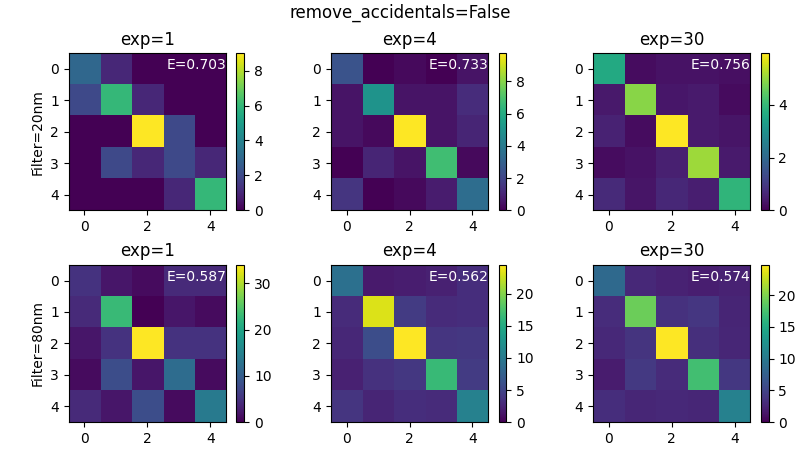

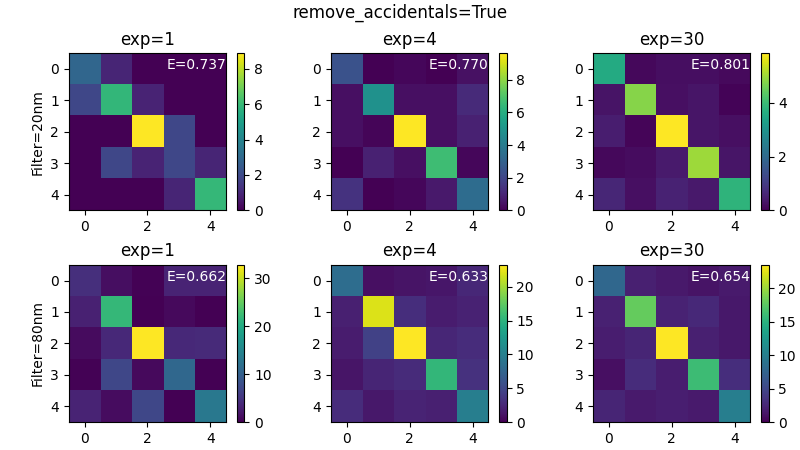

In [11]:
plt.close('all')
def get_scan(filter_type, exp_time):
    path = glob.glob(rf'{dir_path}\*filter_{filter_type}nm_exp_{exp_time}s.dscan')[0]
    d = DiscreetScanResult()
    d.loadfrom(path)
    return d

def show_coin(s, ax, real_coin=False):
    c = s.real_coins if real_coin else s.coincidences
    imm = ax.imshow(c, vmin=0)
    ax.figure.colorbar(imm, ax=ax)
    ax.set_title(f'exp={s.integration_time}')
    ax.text(2.6, 0, f'E={np.diag(c).sum() / c.sum():.3f}', color='white')

for opt in [False, True]:
    fig, axes = plt.subplots(2, 3, constrained_layout=True, figsize=(8, 4.5))
    for j, filt in enumerate([20, 80]):
        for i, exp_time in enumerate([1, 4, 30]):
            show_coin(get_scan(filt, exp_time), axes[j, i], real_coin=opt)
    fig.suptitle(f'remove_accidentals={opt}')
    axes[0, 0].set_ylabel('Filter=20nm')
    _ = axes[1, 0].set_ylabel('Filter=80nm')

For 20nm, 1s is pretty noisy, and 30s is probably enough. For 80nm it seems that 4s is probably enough already. And the fidelity indeed is indeed significantly worse for 80nm. However, it might just be that the optimal input phases are different.  So let's reoptimize the input phases, this time with the 80nm filters. After doing that, we get the following correlations: 

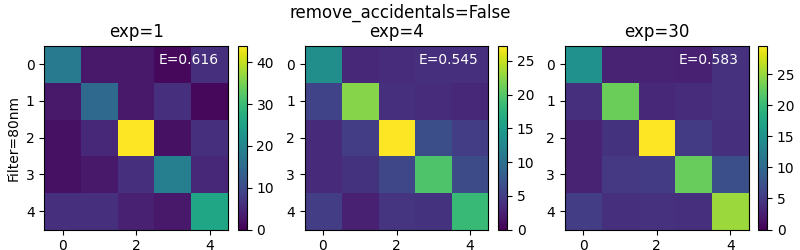

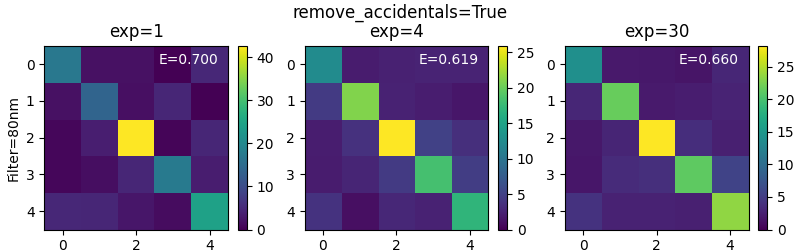

In [12]:
def get_scan2(filter_type, exp_time):
    path = glob.glob(rf'{dir_path}\*filter_{filter_type}nm_exp_{exp_time}s_phases_80nm.dscan')[0]
    d = DiscreetScanResult()
    d.loadfrom(path)
    return d
for opt in [False, True]:
    fig, axes = plt.subplots(1, 3, constrained_layout=True, figsize=(8, 2.5))
    for i, exp_time in enumerate([1, 4, 30]):
        show_coin(get_scan2(80, exp_time), axes[i], real_coin=opt)
    
    fig.suptitle(f'remove_accidentals={opt}')
    _ = axes[0].set_ylabel('Filter=80nm')

## Conclusion
So I guess the 80nm filters indeed reduce the fidelity of the transformation. An interesting question is - why? We see that the single counts looks fine, which makes me think the the MPLC bandwidth is OK (though I should probably simulate it at some point). Maybe it is only hard to find good correction phases with such a big bandwidth? 

A relevant check is to see how the two-photon speckle will look. How different will it look from the 20nm speckle? What will be the contrast? The next relevant question really is how well we will be able to focus it. But that is in the future.  

## small aside 

I actually started with doing a short phase optimization (6s integration time), looked quickly once at the result with a 1s scan, and then did another slightly longer phase optimization (10s integration). This is what happened with the medium phases: 

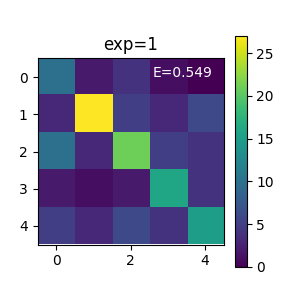

In [13]:
path = r"G:\My Drive\Projects\MPLC\results\lab\2024_09_19_filters_80nm\2024_09_19_14_13_45_filter_80nm_exp_1s.dscan"
d = DiscreetScanResult()
d.loadfrom(path)

fig, ax = plt.subplots(figsize=(3, 3))
show_coin(d, ax)

# Speckles

Finally, we meaure a two-photon speckle with the 80nm filters, and compare to the speckle we measured with 20nm filters which needed an integration time of 60s. For the 80nm filter I used 15s integration time. 

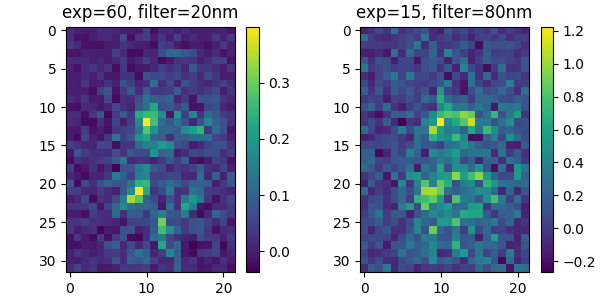

In [7]:
plt.close('all')
speckles_20_path = glob.glob(rf'{dir_path}\*two_ph_speckle*d1d*filter_20nm*.scan')[0]
speckles_20 = ScanResult(path=speckles_20_path)

speckles_80_path = r"G:\My Drive\Projects\MPLC\results\lab\2024_09_19_filters_80nm\2024_09_24_09_50_09_two_ph_speckles_d1d_exp_15s_filter_80nm.scan"
speckles_80 = ScanResult(path=speckles_80_path)

def show(s, ax, title):
    imm = ax.imshow(s.real_coins)
    ax.figure.colorbar(imm, ax=ax)
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3))

show(speckles_20, axes[0], title=f'exp={speckles_20.integration_time}, filter=20nm')
show(speckles_80, axes[1], title=f'exp={speckles_80.integration_time}, filter=80nm')

The contrast seems to be slightly worse in the 80nm. 

It is interesting also to look at the single counts. If more features wash out it means that indeed we have a few spectral modes. In reality it seems maybe a tiny bit washed out. Not more than 2-3 spectral modes for sure. But I'm not sure whether it is 1.01, 1.1, or 2 spectral modes. 

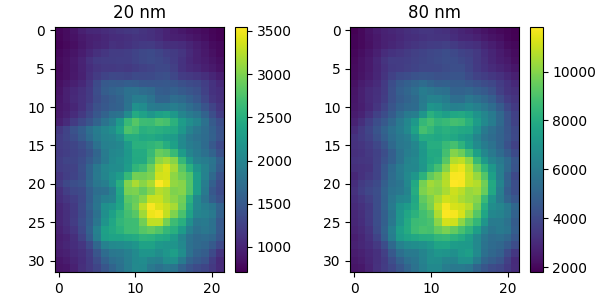

In [8]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3))
imm = axes[0].imshow(speckles_20.single2s)
fig.colorbar(imm, ax=axes[0])
axes[0].set_title('20 nm')
imm = axes[1].imshow(speckles_80.single2s)
axes[1].set_title('80 nm')
fig.colorbar(imm, ax=axes[1])

Quantifying the contrast of the two-photon speckle it seems that the 20nm have 1.2 modes, and the 80nm has 2. Which means it is not so good but not so bad... In the single counts I don't really believe the measurements. 

In [9]:
print('Speckles 20nm coincidence')
c20 = speckles_20.coincidences.std() / speckles_20.coincidences.mean()
N_modes20 = 1/c20**2
print(rf'contrast: {c20:.3f}, N_modes: {N_modes20:.3f}')

print('Speckles 80nm coincidence')
c80 = speckles_80.coincidences.std() / speckles_80.coincidences.mean()
N_modes80 = 1/c80**2
print(rf'contrast: {c80:.3f}, N_modes: {N_modes80:.3f}')

print()

print('Speckles 20nm singles')
c20 = speckles_20.single2s.std() / speckles_20.single2s.mean()
N_modes20 = 1/c20**2
print(rf'contrast: {c20:.3f}, N_modes: {N_modes20:.3f}')

print('Speckles 80nm singles')
c80 = speckles_80.single2s.std() / speckles_80.single2s.mean()
N_modes80 = 1/c80**2
print(rf'contrast: {c80:.3f}, N_modes: {N_modes80:.3f}')

Speckles 20nm coincidence
contrast: 0.895, N_modes: 1.247
Speckles 80nm coincidence
contrast: 0.693, N_modes: 2.083

Speckles 20nm singles
contrast: 0.387, N_modes: 6.661
Speckles 80nm singles
contrast: 0.445, N_modes: 5.048


The very bottom line is that 80nm filters could probably work if and when I want to do thinks quick and dirty, but in the final results I will probably want to use 20nm filters. 